In [15]:
import pandas as pd
import os
from datetime import datetime
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from fbprophet import Prophet
import plotly
from fbprophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('raw_data_2017/01Jan2017.csv').drop(['Unnamed: 0'], axis = 1)
for year in range(2017,2021):
    for file in os.listdir(f'raw_data_{year}'):
        if file[-3:] == 'csv':
            df_new = pd.read_csv(f'raw_data_{year}/{file}').drop(['Unnamed: 0'], axis=1)
            df_new.time = df_new.time.apply(lambda x: file[:-4])
            df = pd.concat([df, df_new]).reset_index(drop=True)
df.head()


,text,time,score
0,"I don't know how many of you read it, but a fe...",01Jan2017,6
1,[deleted],01Jan2017,10
2,The reason that it occurred to me that I may h...,01Jan2017,1
3,Sometimes I don't really feel like a participa...,01Jan2017,5
4,[deleted],01Jan2017,3


In [3]:
df.time = df.time.apply(lambda x: datetime.strptime(x, '%d%b%Y'))
df = df.sort_values('time')

In [4]:
dates = sorted([datetime.strftime(datetime.strptime(file[:-4], '%d%b%Y'), '%Y-%m-%d') \
                for year in range(2017, 2021) \
                for file in os.listdir(f'raw_data_{year}') \
                if file[-3:] == 'csv'])
data = []
df_text = df[df['text'] != '[deleted]']

for date in dates:
    data.append(df_text[df_text['time'] == datetime.strptime(date, '%Y-%m-%d')])

In [5]:
#prophet expects a dataframe with (date, value)
prophet_input = pd.DataFrame(columns = ['ds','y'])
analyzer = SentimentIntensityAnalyzer()
for i in tqdm(range(0, len(data))):
    texts = data[i]['text'].values
    date = data[i]['time'].iloc[0] #date will be the same for all values in list, just pick first
    #iterate over the posts in the texts list
    for j in texts:
        try:
            vs = analyzer.polarity_scores(j)
            new_data = pd.DataFrame([[date, vs['compound']]], columns = ['ds','y'])
            prophet_input = pd.concat([prophet_input, new_data], ignore_index = True)
        except:
            print("We couldn't process this post because it was: ", j)
            continue


  0%|          | 0/732 [00:00<?, ?it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  0%|          | 1/732 [00:00<07:06,  1.71it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  0%|          | 2/732 [00:00<05:00,  2.43it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  0%|          | 3/732 [00:01<04:00,  3.03it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  1%|          | 5/732 [00:01<03:09,  3.83it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  1%|          | 6/732 [00:01<03:07,  3.88it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

  1%|          | 8/732 [00:02<02:20,  5.15it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

  1%|          | 9/732 [00:02<03:30,  3.43it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  1%|▏         | 10/732 [00:02<02:59,  4.03it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

  2%|▏         | 12/732 [00:03<02:26,  4.90it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

  2%|▏         | 13/732 [00:03<03:22,  3.55it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  2%|▏         | 15/732 [00:04<03:26,  3.48it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  2%|▏         | 16/732 [00:04<03:30,  3.41it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  2%|▏         | 17/732 [00:04<03:15,  3.65it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  2%|▏         | 18/732 [00:04<02:52,  4.14it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  3%|▎         | 20/732 [00:05<02:30,  4.72it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

  3%|▎         | 21/732 [00:05<02:18,  5.15it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  3%|▎         | 22/732 [00:05<02:54,  4.08it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  3%|▎         | 23/732 [00:06<03:10,  3.73it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  3%|▎         | 24/732 [00:06<03:29,  3.39it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  4%|▎         | 26/732 [00:06<02:30,  4.70it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

  4%|▎         | 27/732 [00:06<02:24,  4.86it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  4%|▍         | 28/732 [00:07<02:36,  4.49it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

  4%|▍         | 29/732 [00:07<02:43,  4.30it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  4%|▍         | 31/732 [00:07<02:19,  5.02it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  4%|▍         | 32/732 [00:08<02:29,  4.67it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  5%|▍         | 34/732 [00:08<03:35,  3.24it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

  5%|▍         | 35/732 [00:10<08:27,  1.37it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  5%|▍         | 36/732 [00:11<08:28,  1.37it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

  5%|▌         | 37/732 [00:11<06:41,  1.73it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

  5%|▌         | 38/732 [00:11<05:14,  2.21it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was: 

  5%|▌         | 40/732 [00:12<03:44,  3.09it/s]

 nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  6%|▌         | 41/732 [00:12<03:04,  3.75it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

  6%|▌         | 42/732 [00:12<03:38,  3.16it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  6%|▌         | 43/732 [00:12<03:25,  3.36it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  6%|▌         | 44/732 [00:13<03:33,  3.23it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  6%|▋         | 46/732 [00:13<02:30,  4.56it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

  6%|▋         | 47/732 [00:14<04:49,  2.37it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  7%|▋         | 48/732 [00:14<03:57,  2.88it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  7%|▋         | 49/732 [00:14<03:56,  2.89it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  7%|▋         | 50/732 [00:15<04:08,  2.75it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  7%|▋         | 51/732 [00:15<04:08,  2.74it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  7%|▋         | 52/732 [00:16<03:44,  3.03it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  7%|▋         | 53/732 [00:16<03:20,  3.39it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

  7%|▋         | 54/732 [00:16<04:00,  2.82it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

  8%|▊         | 55/732 [00:17<03:52,  2.92it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

  8%|▊         | 56/732 [00:17<03:40,  3.06it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

  8%|▊         | 57/732 [00:17<03:54,  2.88it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  8%|▊         | 59/732 [00:18<02:58,  3.78it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

  8%|▊         | 60/732 [00:18<04:37,  2.42it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  8%|▊         | 61/732 [00:19<03:59,  2.80it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

  8%|▊         | 62/732 [00:19<04:00,  2.79it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

  9%|▊         | 63/732 [00:19<03:34,  3.12it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


  9%|▊         | 64/732 [00:19<03:26,  3.24it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

  9%|▉         | 66/732 [00:20<03:51,  2.87it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

  9%|▉         | 67/732 [00:21<03:39,  3.03it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

  9%|▉         | 68/732 [00:21<05:00,  2.21it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 10%|▉         | 70/732 [00:22<04:18,  2.56it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 10%|▉         | 71/732 [00:22<04:19,  2.55it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan

 10%|▉         | 72/732 [00:23<04:31,  2.43it/s]


We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 10%|▉         | 73/732 [00:23<04:45,  2.31it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 10%|█         | 74/732 [00:24<04:13,  2.60it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 10%|█         | 75/732 [00:24<04:54,  2.23it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 10%|█         | 76/732 [00:25<06:28,  1.69it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 11%|█         | 77/732 [00:25<05:32,  1.97it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 11%|█         | 78/732 [00:26<05:10,  2.10it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 11%|█         | 79/732 [00:26<04:28,  2.44it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 11%|█         | 80/732 [00:26<04:00,  2.71it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 11%|█         | 81/732 [00:27<03:29,  3.10it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 11%|█         | 82/732 [00:27<03:25,  3.16it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 11%|█▏        | 83/732 [00:27<03:48,  2.84it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 11%|█▏        | 84/732 [00:28<04:53,  2.21it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 12%|█▏        | 85/732 [00:28<04:44,  2.27it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 12%|█▏        | 86/732 [00:29<04:26,  2.42it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 12%|█▏        | 87/732 [00:30<05:56,  1.81it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 12%|█▏        | 88/732 [00:30<05:04,  2.12it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 12%|█▏        | 89/732 [00:30<04:40,  2.30it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 12%|█▏        | 90/732 [00:31<04:53,  2.19it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 13%|█▎        | 92/732 [00:31<03:22,  3.15it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 13%|█▎        | 94/732 [00:32<03:03,  3.48it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 13%|█▎        | 95/732 [00:32<03:20,  3.17it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 13%|█▎        | 96/732 [00:32<03:25,  3.10it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 13%|█▎        | 97/732 [00:33<05:14,  2.02it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 13%|█▎        | 98/732 [00:34<04:37,  2.29it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 14%|█▎        | 100/732 [00:34<03:13,  3.27it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 14%|█▍        | 101/732 [00:34<02:47,  3.76it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 14%|█▍        | 102/732 [00:34<02:38,  3.97it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 14%|█▍        | 103/732 [00:36<06:39,  1.57it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 14%|█▍        | 104/732 [00:36<06:19,  1.66it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 14%|█▍        | 105/732 [00:37<05:36,  1.86it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 14%|█▍        | 106/732 [00:37<05:34,  1.87it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 16%|█▌        | 114/732 [00:41<06:03,  1.70it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 16%|█▌        | 115/732 [00:42<06:26,  1.60it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 16%|█▌        | 116/732 [00:42<05:26,  1.89it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 16%|█▌        | 117/732 [00:43<05:21,  1.91it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 16%|█▌        | 118/732 [00:43<04:38,  2.21it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 16%|█▋        | 119/732 [00:44<04:08,  2.47it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 16%|█▋        | 120/732 [00:44<03:38,  2.80it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 17%|█▋        | 121/732 [00:45<05:08,  1.98it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 17%|█▋        | 122/732 [00:45<05:02,  2.02it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 17%|█▋        | 123/732 [00:45<04:28,  2.27it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 17%|█▋        | 124/732 [00:46<04:22,  2.32it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 17%|█▋        | 125/732 [00:46<04:26,  2.28it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 17%|█▋        | 126/732 [00:47<03:46,  2.68it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was: 

 17%|█▋        | 127/732 [00:47<03:26,  2.93it/s]

 nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this p

 17%|█▋        | 128/732 [00:47<03:31,  2.86it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 18%|█▊        | 129/732 [00:47<03:22,  2.98it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 18%|█▊        | 130/732 [00:48<03:08,  3.19it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 18%|█▊        | 131/732 [00:48<03:37,  2.76it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 18%|█▊        | 132/732 [00:48<03:11,  3.14it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 18%|█▊        | 133/732 [00:49<04:53,  2.04it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 18%|█▊        | 134/732 [00:50<05:56,  1.68it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 18%|█▊        | 135/732 [00:50<05:01,  1.98it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 19%|█▊        | 136/732 [00:51<05:00,  1.99it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 19%|█▊        | 137/732 [00:51<04:31,  2.19it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 19%|█▉        | 138/732 [00:52<04:14,  2.33it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 19%|█▉        | 140/732 [00:52<03:04,  3.20it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 19%|█▉        | 141/732 [00:52<03:01,  3.25it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 19%|█▉        | 142/732 [00:53<03:45,  2.62it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 20%|█▉        | 143/732 [00:54<04:37,  2.13it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 20%|█▉        | 144/732 [00:54<03:42,  2.64it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  

 20%|█▉        | 145/732 [00:54<03:20,  2.93it/s]

nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 20%|█▉        | 146/732 [00:54<03:03,  3.20it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 20%|██        | 147/732 [00:55<02:58,  3.27it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 20%|██        | 148/732 [00:55<03:31,  2.76it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 20%|██        | 149/732 [00:56<04:11,  2.32it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 20%|██        | 150/732 [00:56<03:25,  2.83it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 21%|██        | 151/732 [00:56<03:34,  2.71it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 21%|██        | 152/732 [00:57<05:13,  1.85it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 21%|██        | 153/732 [00:58<06:10,  1.56it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was: 

 21%|██        | 154/732 [00:58<05:13,  1.84it/s]

 nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 21%|██        | 155/732 [00:59<05:53,  1.63it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 21%|██▏       | 156/732 [01:00<05:24,  1.77it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 21%|██▏       | 157/732 [01:00<05:02,  1.90it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 22%|██▏       | 158/732 [01:01<05:31,  1.73it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 22%|██▏       | 159/732 [01:01<04:44,  2.01it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 22%|██▏       | 160/732 [01:01<04:36,  2.07it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 22%|██▏       | 161/732 [01:02<04:45,  2.00it/s]

We couldn't process this post because it was:  nan


 22%|██▏       | 162/732 [01:02<04:31,  2.10it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 22%|██▏       | 164/732 [01:03<03:20,  2.84it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 23%|██▎       | 165/732 [01:03<03:11,  2.96it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 23%|██▎       | 166/732 [01:04<03:30,  2.68it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 23%|██▎       | 167/732 [01:05<05:01,  1.87it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 23%|██▎       | 168/732 [01:06<07:05,  1.32it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 23%|██▎       | 169/732 [01:06<05:58,  1.57it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 23%|██▎       | 170/732 [01:07<05:16,  1.77it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 23%|██▎       | 171/732 [01:08<08:03,  1.16it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 23%|██▎       | 172/732 [01:08<06:15,  1.49it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 24%|██▎       | 173/732 [01:09<05:54,  1.58it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 24%|██▍       | 174/732 [01:10<05:54,  1.58it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 24%|██▍       | 175/732 [01:10<05:07,  1.81it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 24%|██▍       | 176/732 [01:11<05:35,  1.66it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 24%|██▍       | 177/732 [01:12<06:41,  1.38it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 24%|██▍       | 178/732 [01:12<05:40,  1.63it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 24%|██▍       | 179/732 [01:12<04:54,  1.88it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 25%|██▍       | 180/732 [01:14<08:35,  1.07it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 25%|██▍       | 181/732 [01:15<08:24,  1.09it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 25%|██▍       | 182/732 [01:16<07:45,  1.18it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 25%|██▌       | 183/732 [01:17<07:23,  1.24it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 25%|██▌       | 184/732 [01:17<05:59,  1.52it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 25%|██▌       | 185/732 [01:17<05:27,  1.67it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 25%|██▌       | 186/732 [01:18<05:49,  1.56it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 26%|██▌       | 187/732 [01:18<05:01,  1.81it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 26%|██▌       | 188/732 [01:19<04:33,  1.99it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 26%|██▌       | 189/732 [01:19<04:42,  1.92it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 26%|██▌       | 190/732 [01:20<04:46,  1.89it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 26%|██▌       | 191/732 [01:20<04:47,  1.88it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 26%|██▌       | 192/732 [01:21<04:18,  2.09it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 26%|██▋       | 193/732 [01:21<04:51,  1.85it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 27%|██▋       | 194/732 [01:22<05:07,  1.75it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 27%|██▋       | 195/732 [01:23<05:03,  1.77it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 27%|██▋       | 196/732 [01:23<05:21,  1.67it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 27%|██▋       | 197/732 [01:24<05:00,  1.78it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 27%|██▋       | 198/732 [01:25<05:32,  1.60it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 27%|██▋       | 199/732 [01:25<05:21,  1.66it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 27%|██▋       | 200/732 [01:26<04:57,  1.79it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 27%|██▋       | 201/732 [01:27<05:54,  1.50it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 28%|██▊       | 202/732 [01:27<05:47,  1.52it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 28%|██▊       | 203/732 [01:28<06:10,  1.43it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 28%|██▊       | 204/732 [01:28<04:57,  1.78it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 28%|██▊       | 205/732 [01:29<05:16,  1.66it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 28%|██▊       | 206/732 [01:29<05:14,  1.67it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 28%|██▊       | 207/732 [01:30<04:40,  1.87it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 28%|██▊       | 208/732 [01:30<04:40,  1.87it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 29%|██▊       | 209/732 [01:31<05:03,  1.72it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 29%|██▊       | 210/732 [01:32<05:08,  1.69it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 29%|██▉       | 211/732 [01:32<05:27,  1.59it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 29%|██▉       | 212/732 [01:33<04:45,  1.82it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 29%|██▉       | 213/732 [01:33<05:01,  1.72it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 29%|██▉       | 214/732 [01:34<05:04,  1.70it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 29%|██▉       | 215/732 [01:34<04:40,  1.85it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 30%|██▉       | 216/732 [01:35<04:13,  2.04it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 30%|██▉       | 217/732 [01:35<04:04,  2.11it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 30%|██▉       | 218/732 [01:38<10:18,  1.20s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 30%|██▉       | 219/732 [01:39<09:46,  1.14s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 30%|███       | 220/732 [01:40<08:04,  1.06it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 30%|███       | 221/732 [01:40<06:38,  1.28it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 30%|███       | 222/732 [01:41<06:07,  1.39it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 30%|███       | 223/732 [01:41<05:21,  1.58it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 31%|███       | 224/732 [01:41<04:43,  1.79it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 31%|███       | 225/732 [01:42<04:59,  1.69it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 31%|███       | 226/732 [01:43<04:58,  1.69it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 31%|███       | 227/732 [01:43<04:37,  1.82it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 31%|███       | 228/732 [01:44<05:37,  1.50it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 31%|███▏      | 229/732 [01:45<05:25,  1.55it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 31%|███▏      | 230/732 [01:45<05:30,  1.52it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 32%|███▏      | 231/732 [01:46<05:33,  1.50it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 32%|███▏      | 232/732 [01:47<05:35,  1.49it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 32%|███▏      | 233/732 [01:47<05:21,  1.55it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 32%|███▏      | 234/732 [01:48<05:22,  1.54it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 32%|███▏      | 235/732 [01:48<04:58,  1.66it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 32%|███▏      | 236/732 [01:49<05:23,  1.54it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 32%|███▏      | 237/732 [01:50<06:28,  1.28it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 33%|███▎      | 238/732 [01:51<06:18,  1.31it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 33%|███▎      | 239/732 [01:52<07:00,  1.17it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 33%|███▎      | 240/732 [01:53<07:07,  1.15it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 33%|███▎      | 241/732 [01:54<07:36,  1.07it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 33%|███▎      | 242/732 [01:55<06:46,  1.21it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 33%|███▎      | 243/732 [01:55<06:34,  1.24it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 33%|███▎      | 244/732 [01:56<05:53,  1.38it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 33%|███▎      | 245/732 [01:56<05:12,  1.56it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 34%|███▎      | 246/732 [01:57<05:12,  1.56it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 34%|███▎      | 247/732 [01:58<05:02,  1.60it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 34%|███▍      | 248/732 [01:59<06:24,  1.26it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 34%|███▍      | 249/732 [01:59<05:29,  1.47it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 34%|███▍      | 250/732 [02:01<06:53,  1.17it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 34%|███▍      | 251/732 [02:01<05:43,  1.40it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 34%|███▍      | 252/732 [02:02<06:07,  1.31it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 35%|███▍      | 253/732 [02:02<05:20,  1.49it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 35%|███▍      | 254/732 [02:03<05:25,  1.47it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 35%|███▍      | 255/732 [02:04<06:04,  1.31it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post b

 35%|███▍      | 256/732 [02:05<06:17,  1.26it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 35%|███▌      | 257/732 [02:06<06:24,  1.23it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 35%|███▌      | 258/732 [02:06<06:17,  1.26it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 35%|███▌      | 259/732 [02:08<07:28,  1.06it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 36%|███▌      | 260/732 [02:09<07:31,  1.05it/s]

We couldn't process this post because it was:  nan


 36%|███▌      | 261/732 [02:09<06:36,  1.19it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 36%|███▌      | 262/732 [02:10<06:59,  1.12it/s]

We couldn't process this post because it was:  nan


 36%|███▌      | 263/732 [02:11<06:30,  1.20it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 36%|███▌      | 264/732 [02:14<11:17,  1.45s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 36%|███▌      | 265/732 [02:15<09:44,  1.25s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 36%|███▋      | 266/732 [02:16<08:53,  1.15s/it]

We couldn't process this post because it was:  nan


 36%|███▋      | 267/732 [02:16<08:08,  1.05s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 37%|███▋      | 268/732 [02:17<08:18,  1.07s/it]

We couldn't process this post because it was:  nan


 37%|███▋      | 269/732 [02:18<07:15,  1.06it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 37%|███▋      | 271/732 [02:20<07:27,  1.03it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 37%|███▋      | 272/732 [02:21<06:57,  1.10it/s]

We couldn't process this post because it was:  nan


 37%|███▋      | 273/732 [02:22<07:25,  1.03it/s]

We couldn't process this post because it was:  nan


 37%|███▋      | 274/732 [02:23<07:57,  1.04s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 38%|███▊      | 275/732 [02:24<08:08,  1.07s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 38%|███▊      | 276/732 [02:26<08:30,  1.12s/it]

We couldn't process this post because it was:  nan


 38%|███▊      | 277/732 [02:27<09:12,  1.22s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 38%|███▊      | 278/732 [02:28<07:51,  1.04s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 38%|███▊      | 279/732 [02:28<07:04,  1.07it/s]

We couldn't process this post because it was:  nan


 38%|███▊      | 280/732 [02:29<07:10,  1.05it/s]

We couldn't process this post because it was:  nan


 38%|███▊      | 281/732 [02:30<06:42,  1.12it/s]

We couldn't process this post because it was:  nan


 39%|███▊      | 282/732 [02:31<06:45,  1.11it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 39%|███▊      | 283/732 [02:32<06:29,  1.15it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 39%|███▉      | 284/732 [02:33<07:05,  1.05it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 39%|███▉      | 285/732 [02:35<09:53,  1.33s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 39%|███▉      | 286/732 [02:37<09:52,  1.33s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 39%|███▉      | 287/732 [02:37<08:36,  1.16s/it]

We couldn't process this post because it was:  nan


 39%|███▉      | 288/732 [02:38<07:26,  1.01s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 39%|███▉      | 289/732 [02:39<06:59,  1.06it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 40%|███▉      | 290/732 [02:40<06:22,  1.15it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 40%|███▉      | 291/732 [02:41<06:45,  1.09it/s]

We couldn't process this post because it was:  nan


 40%|███▉      | 292/732 [02:42<06:51,  1.07it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 40%|████      | 293/732 [02:44<09:12,  1.26s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 40%|████      | 294/732 [02:45<09:18,  1.28s/it]

We couldn't process this post because it was:  nan


 40%|████      | 295/732 [02:46<09:31,  1.31s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 40%|████      | 296/732 [02:47<08:49,  1.21s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 41%|████      | 297/732 [02:48<07:49,  1.08s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 41%|████      | 298/732 [02:48<06:30,  1.11it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 41%|████      | 299/732 [02:49<05:49,  1.24it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 41%|████      | 300/732 [02:50<05:35,  1.29it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 41%|████      | 301/732 [02:50<05:25,  1.32it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 41%|████▏     | 302/732 [02:51<05:09,  1.39it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 41%|████▏     | 303/732 [02:52<05:52,  1.22it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 42%|████▏     | 304/732 [02:53<06:04,  1.17it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 42%|████▏     | 305/732 [02:55<07:49,  1.10s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 42%|████▏     | 306/732 [02:55<06:51,  1.04it/s]

We couldn't process this post because it was:  nan


 42%|████▏     | 307/732 [02:56<07:04,  1.00it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 42%|████▏     | 308/732 [02:58<08:58,  1.27s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 42%|████▏     | 309/732 [02:59<07:39,  1.09s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 42%|████▏     | 310/732 [03:00<07:32,  1.07s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 42%|████▏     | 311/732 [03:01<07:03,  1.01s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 43%|████▎     | 312/732 [03:02<06:24,  1.09it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 43%|████▎     | 313/732 [03:03<06:28,  1.08it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 43%|████▎     | 314/732 [03:04<06:35,  1.06it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 43%|████▎     | 315/732 [03:05<06:39,  1.04it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 43%|████▎     | 316/732 [03:06<07:00,  1.01s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 43%|████▎     | 317/732 [03:08<09:17,  1.34s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 43%|████▎     | 318/732 [03:09<09:18,  1.35s/it]

We couldn't process this post because it was:  nan


 44%|████▎     | 319/732 [03:10<07:46,  1.13s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 44%|████▎     | 320/732 [03:11<07:33,  1.10s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 44%|████▍     | 321/732 [03:12<07:23,  1.08s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 44%|████▍     | 322/732 [03:13<07:23,  1.08s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 44%|████▍     | 323/732 [03:14<07:55,  1.16s/it]

We couldn't process this post because it was:  nan


 44%|████▍     | 324/732 [03:16<08:31,  1.25s/it]

We couldn't process this post because it was:  nan


 44%|████▍     | 325/732 [03:17<09:05,  1.34s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 45%|████▍     | 326/732 [03:18<08:30,  1.26s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 45%|████▍     | 327/732 [03:20<09:47,  1.45s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 45%|████▍     | 328/732 [03:21<08:44,  1.30s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 45%|████▍     | 329/732 [03:22<08:18,  1.24s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 45%|████▌     | 330/732 [03:25<11:30,  1.72s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 45%|████▌     | 331/732 [03:26<10:18,  1.54s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 45%|████▌     | 332/732 [03:28<09:42,  1.46s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 45%|████▌     | 333/732 [03:29<08:59,  1.35s/it]

We couldn't process this post because it was:  nan


 46%|████▌     | 334/732 [03:30<08:06,  1.22s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 46%|████▌     | 335/732 [03:31<08:24,  1.27s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 46%|████▌     | 336/732 [03:32<08:22,  1.27s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 46%|████▌     | 337/732 [03:34<10:10,  1.55s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 46%|████▌     | 338/732 [03:37<11:39,  1.78s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 46%|████▋     | 339/732 [03:38<11:10,  1.70s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 46%|████▋     | 340/732 [03:39<09:33,  1.46s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 47%|████▋     | 341/732 [03:41<09:33,  1.47s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 47%|████▋     | 342/732 [03:43<11:17,  1.74s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 47%|████▋     | 343/732 [03:45<10:48,  1.67s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 47%|████▋     | 344/732 [03:46<09:47,  1.51s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 47%|████▋     | 345/732 [03:48<10:26,  1.62s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 47%|████▋     | 346/732 [03:48<08:40,  1.35s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 47%|████▋     | 347/732 [03:49<08:26,  1.32s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 48%|████▊     | 348/732 [03:52<10:05,  1.58s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 48%|████▊     | 349/732 [03:53<08:45,  1.37s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 48%|████▊     | 350/732 [03:54<08:25,  1.32s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 48%|████▊     | 351/732 [03:54<06:58,  1.10s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 48%|████▊     | 352/732 [03:56<07:55,  1.25s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 48%|████▊     | 353/732 [03:57<07:39,  1.21s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 48%|████▊     | 354/732 [03:58<07:42,  1.22s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 48%|████▊     | 355/732 [04:00<07:57,  1.27s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 49%|████▊     | 356/732 [04:01<08:46,  1.40s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 49%|████▉     | 357/732 [04:03<08:19,  1.33s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 49%|████▉     | 358/732 [04:04<08:17,  1.33s/it]

We couldn't process this post because it was:  nan


 49%|████▉     | 359/732 [04:05<08:07,  1.31s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 49%|████▉     | 360/732 [04:06<07:44,  1.25s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 49%|████▉     | 361/732 [04:07<06:39,  1.08s/it]

We couldn't process this post because it was:  nan


 49%|████▉     | 362/732 [04:08<06:03,  1.02it/s]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 50%|████▉     | 363/732 [04:09<06:09,  1.00s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 50%|████▉     | 364/732 [04:11<07:46,  1.27s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 50%|████▉     | 365/732 [04:12<08:11,  1.34s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 50%|█████     | 366/732 [04:13<07:37,  1.25s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 50%|█████     | 367/732 [04:14<07:15,  1.19s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 50%|█████     | 368/732 [04:16<08:25,  1.39s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 50%|█████     | 369/732 [04:17<07:29,  1.24s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 51%|█████     | 370/732 [04:19<08:17,  1.37s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 51%|█████     | 371/732 [04:20<07:59,  1.33s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 51%|█████     | 372/732 [04:22<08:55,  1.49s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 51%|█████     | 373/732 [04:24<09:35,  1.60s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 51%|█████     | 374/732 [04:25<09:06,  1.53s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 51%|█████     | 375/732 [04:26<08:46,  1.48s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 51%|█████▏    | 376/732 [04:29<11:04,  1.87s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 52%|█████▏    | 377/732 [04:31<10:17,  1.74s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 52%|█████▏    | 378/732 [04:32<09:31,  1.61s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 52%|█████▏    | 379/732 [04:33<08:34,  1.46s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 52%|█████▏    | 380/732 [04:35<08:47,  1.50s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 52%|█████▏    | 381/732 [04:36<08:47,  1.50s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 52%|█████▏    | 383/732 [04:39<08:17,  1.43s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 52%|█████▏    | 384/732 [04:43<12:32,  2.16s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 53%|█████▎    | 385/732 [04:45<12:22,  2.14s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 53%|█████▎    | 386/732 [04:47<11:44,  2.04s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 53%|█████▎    | 387/732 [04:48<10:51,  1.89s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 53%|█████▎    | 388/732 [04:50<10:58,  1.92s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 53%|█████▎    | 389/732 [04:52<10:33,  1.85s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 53%|█████▎    | 390/732 [04:54<10:12,  1.79s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 53%|█████▎    | 391/732 [04:55<10:00,  1.76s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 54%|█████▎    | 392/732 [04:57<09:23,  1.66s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 54%|█████▎    | 393/732 [04:58<09:18,  1.65s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 54%|█████▍    | 394/732 [05:00<09:15,  1.64s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 54%|█████▍    | 395/732 [05:02<10:14,  1.82s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 54%|█████▍    | 396/732 [05:04<10:02,  1.79s/it]

We couldn't process this post because it was:  nan


 54%|█████▍    | 397/732 [05:05<09:12,  1.65s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 54%|█████▍    | 398/732 [05:09<12:02,  2.16s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 55%|█████▍    | 399/732 [05:10<11:16,  2.03s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 55%|█████▍    | 400/732 [05:13<12:06,  2.19s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 55%|█████▍    | 401/732 [05:16<13:10,  2.39s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 55%|█████▍    | 402/732 [05:19<15:07,  2.75s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 55%|█████▌    | 403/732 [05:22<14:38,  2.67s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 55%|█████▌    | 404/732 [05:24<14:34,  2.67s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 55%|█████▌    | 405/732 [05:27<14:23,  2.64s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 55%|█████▌    | 406/732 [05:29<13:34,  2.50s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 56%|█████▌    | 407/732 [05:31<12:47,  2.36s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 56%|█████▌    | 408/732 [05:33<11:26,  2.12s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 56%|█████▌    | 409/732 [05:35<11:12,  2.08s/it]

We couldn't process this post because it was:  nan


 56%|█████▌    | 410/732 [05:37<10:53,  2.03s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 56%|█████▌    | 411/732 [05:38<09:39,  1.81s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 56%|█████▋    | 412/732 [05:39<08:59,  1.68s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 56%|█████▋    | 413/732 [05:41<08:51,  1.67s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 57%|█████▋    | 414/732 [05:44<11:01,  2.08s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 57%|█████▋    | 415/732 [05:46<11:25,  2.16s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 57%|█████▋    | 416/732 [05:49<11:35,  2.20s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 57%|█████▋    | 417/732 [05:51<10:53,  2.08s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 57%|█████▋    | 418/732 [05:52<09:31,  1.82s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 57%|█████▋    | 419/732 [05:54<09:38,  1.85s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 58%|█████▊    | 421/732 [05:56<07:45,  1.50s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 58%|█████▊    | 422/732 [05:57<07:20,  1.42s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 58%|█████▊    | 423/732 [05:59<07:51,  1.53s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 58%|█████▊    | 424/732 [06:01<08:20,  1.63s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 58%|█████▊    | 425/732 [06:03<08:48,  1.72s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 58%|█████▊    | 426/732 [06:04<08:27,  1.66s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 58%|█████▊    | 427/732 [06:06<08:22,  1.65s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 58%|█████▊    | 428/732 [06:08<09:33,  1.89s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 59%|█████▊    | 429/732 [06:10<08:38,  1.71s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 59%|█████▊    | 430/732 [06:12<09:08,  1.82s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 59%|█████▉    | 431/732 [06:13<08:21,  1.67s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 59%|█████▉    | 432/732 [06:15<09:13,  1.84s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 59%|█████▉    | 433/732 [06:18<09:54,  1.99s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 59%|█████▉    | 434/732 [06:20<10:21,  2.08s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 59%|█████▉    | 435/732 [06:22<09:27,  1.91s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 60%|█████▉    | 436/732 [06:23<09:18,  1.89s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 60%|█████▉    | 437/732 [06:26<09:52,  2.01s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 60%|█████▉    | 438/732 [06:27<08:46,  1.79s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 60%|█████▉    | 439/732 [06:28<07:54,  1.62s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 60%|██████    | 440/732 [06:31<08:57,  1.84s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 60%|██████    | 441/732 [06:32<08:09,  1.68s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 60%|██████    | 442/732 [06:33<07:44,  1.60s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 61%|██████    | 443/732 [06:35<08:22,  1.74s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 61%|██████    | 444/732 [06:37<07:39,  1.60s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 61%|██████    | 445/732 [06:38<07:38,  1.60s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 61%|██████    | 446/732 [06:41<09:34,  2.01s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 61%|██████    | 447/732 [06:43<09:04,  1.91s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 61%|██████    | 448/732 [06:44<08:32,  1.80s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 61%|██████▏   | 449/732 [06:46<08:11,  1.74s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 61%|██████▏   | 450/732 [06:48<08:10,  1.74s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 62%|██████▏   | 451/732 [06:49<08:04,  1.72s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 62%|██████▏   | 452/732 [06:51<07:52,  1.69s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 62%|██████▏   | 453/732 [06:53<08:21,  1.80s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 62%|██████▏   | 454/732 [06:55<08:36,  1.86s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 62%|██████▏   | 455/732 [06:57<08:49,  1.91s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 62%|██████▏   | 456/732 [06:59<08:37,  1.87s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 62%|██████▏   | 457/732 [07:00<08:01,  1.75s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 63%|██████▎   | 458/732 [07:02<08:01,  1.76s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 63%|██████▎   | 459/732 [07:03<07:13,  1.59s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 63%|██████▎   | 460/732 [07:04<06:26,  1.42s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 63%|██████▎   | 461/732 [07:05<06:03,  1.34s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 63%|██████▎   | 462/732 [07:08<07:06,  1.58s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 63%|██████▎   | 463/732 [07:09<06:58,  1.56s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 63%|██████▎   | 464/732 [07:10<06:20,  1.42s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 64%|██████▎   | 465/732 [07:11<05:43,  1.29s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 64%|██████▎   | 466/732 [07:13<06:09,  1.39s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 64%|██████▍   | 467/732 [07:14<05:42,  1.29s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 64%|██████▍   | 468/732 [07:15<05:46,  1.31s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 64%|██████▍   | 469/732 [07:17<06:37,  1.51s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 64%|██████▍   | 470/732 [07:18<06:01,  1.38s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 64%|██████▍   | 471/732 [07:19<05:45,  1.33s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 64%|██████▍   | 472/732 [07:21<06:17,  1.45s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 65%|██████▍   | 473/732 [07:23<06:12,  1.44s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 65%|██████▍   | 474/732 [07:23<05:23,  1.25s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 65%|██████▍   | 475/732 [07:25<05:31,  1.29s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 65%|██████▌   | 476/732 [07:26<05:57,  1.40s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 65%|██████▌   | 477/732 [07:28<06:16,  1.47s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 65%|██████▌   | 478/732 [07:30<06:43,  1.59s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 65%|██████▌   | 479/732 [07:32<06:38,  1.58s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 66%|██████▌   | 480/732 [07:33<07:00,  1.67s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 66%|██████▌   | 481/732 [07:35<06:19,  1.51s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 66%|██████▌   | 482/732 [07:38<08:36,  2.07s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 66%|██████▌   | 483/732 [07:39<07:37,  1.84s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 66%|██████▌   | 484/732 [07:41<07:16,  1.76s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 66%|██████▋   | 485/732 [07:43<07:15,  1.77s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 66%|██████▋   | 486/732 [07:45<07:32,  1.84s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 67%|██████▋   | 487/732 [07:46<07:09,  1.75s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 67%|██████▋   | 488/732 [07:47<06:25,  1.58s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 67%|██████▋   | 489/732 [07:49<06:20,  1.57s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 67%|██████▋   | 490/732 [07:51<06:50,  1.70s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 67%|██████▋   | 491/732 [07:52<06:30,  1.62s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 67%|██████▋   | 492/732 [07:54<06:38,  1.66s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 67%|██████▋   | 493/732 [07:56<06:23,  1.60s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 67%|██████▋   | 494/732 [07:57<06:15,  1.58s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 68%|██████▊   | 495/732 [07:58<05:58,  1.51s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 68%|██████▊   | 496/732 [08:00<06:30,  1.65s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 68%|██████▊   | 497/732 [08:02<06:13,  1.59s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 68%|██████▊   | 498/732 [08:04<06:43,  1.72s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 68%|██████▊   | 499/732 [08:06<07:25,  1.91s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 68%|██████▊   | 500/732 [08:09<08:38,  2.23s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 68%|██████▊   | 501/732 [08:11<08:08,  2.11s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 69%|██████▊   | 502/732 [08:12<07:07,  1.86s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 69%|██████▊   | 503/732 [08:14<06:53,  1.80s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 69%|██████▉   | 504/732 [08:15<06:28,  1.70s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 69%|██████▉   | 505/732 [08:17<05:49,  1.54s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 69%|██████▉   | 506/732 [08:19<06:16,  1.67s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 69%|██████▉   | 507/732 [08:20<06:28,  1.73s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 69%|██████▉   | 508/732 [08:22<06:32,  1.75s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 70%|██████▉   | 509/732 [08:24<06:09,  1.66s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 70%|██████▉   | 510/732 [08:26<07:04,  1.91s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 70%|██████▉   | 511/732 [08:28<06:38,  1.80s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 70%|██████▉   | 512/732 [08:29<06:12,  1.69s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 70%|███████   | 513/732 [08:32<07:11,  1.97s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 70%|███████   | 514/732 [08:34<07:25,  2.04s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 70%|███████   | 515/732 [08:35<06:40,  1.85s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 70%|███████   | 516/732 [08:39<08:02,  2.24s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 71%|███████   | 517/732 [08:40<07:13,  2.02s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 71%|███████   | 518/732 [08:42<07:32,  2.11s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 71%|███████   | 519/732 [08:45<08:08,  2.29s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 71%|███████   | 520/732 [08:47<07:23,  2.09s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 71%|███████   | 521/732 [08:49<07:07,  2.03s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 71%|███████▏  | 522/732 [08:51<07:10,  2.05s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 71%|███████▏  | 523/732 [08:53<07:15,  2.08s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 72%|███████▏  | 524/732 [08:55<06:54,  1.99s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 72%|███████▏  | 525/732 [08:57<07:06,  2.06s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 72%|███████▏  | 526/732 [08:58<06:23,  1.86s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 72%|███████▏  | 527/732 [09:00<06:26,  1.89s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 72%|███████▏  | 528/732 [09:03<07:00,  2.06s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 72%|███████▏  | 529/732 [09:05<07:34,  2.24s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 72%|███████▏  | 530/732 [09:07<07:12,  2.14s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 73%|███████▎  | 531/732 [09:09<07:11,  2.15s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 73%|███████▎  | 532/732 [09:11<06:11,  1.86s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 73%|███████▎  | 533/732 [09:12<06:04,  1.83s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 73%|███████▎  | 534/732 [09:14<05:57,  1.80s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 73%|███████▎  | 535/732 [09:16<05:43,  1.74s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 73%|███████▎  | 536/732 [09:19<06:48,  2.08s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 73%|███████▎  | 537/732 [09:20<06:06,  1.88s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 73%|███████▎  | 538/732 [09:22<06:16,  1.94s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 74%|███████▎  | 539/732 [09:26<07:50,  2.44s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 74%|███████▍  | 540/732 [09:27<06:36,  2.07s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 74%|███████▍  | 541/732 [09:28<05:58,  1.88s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 74%|███████▍  | 542/732 [09:30<05:45,  1.82s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 74%|███████▍  | 543/732 [09:32<06:07,  1.94s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 74%|███████▍  | 544/732 [09:33<05:25,  1.73s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 74%|███████▍  | 545/732 [09:35<05:17,  1.70s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 75%|███████▍  | 546/732 [09:37<05:13,  1.68s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 75%|███████▍  | 547/732 [09:39<05:17,  1.72s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 75%|███████▍  | 548/732 [09:40<04:56,  1.61s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 75%|███████▌  | 549/732 [09:41<04:39,  1.53s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 75%|███████▌  | 550/732 [09:43<04:56,  1.63s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 75%|███████▌  | 551/732 [09:46<05:39,  1.87s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 75%|███████▌  | 552/732 [09:47<05:26,  1.81s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 76%|███████▌  | 553/732 [09:50<05:55,  1.99s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 76%|███████▌  | 554/732 [09:52<05:57,  2.01s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 76%|███████▌  | 555/732 [09:54<06:00,  2.04s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 76%|███████▌  | 556/732 [09:56<05:48,  1.98s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 76%|███████▌  | 557/732 [09:58<06:19,  2.17s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 76%|███████▌  | 558/732 [10:01<06:55,  2.39s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 76%|███████▋  | 559/732 [10:03<06:15,  2.17s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 77%|███████▋  | 560/732 [10:05<06:27,  2.25s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 77%|███████▋  | 561/732 [10:07<05:37,  1.98s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 77%|███████▋  | 562/732 [10:08<05:12,  1.84s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 77%|███████▋  | 563/732 [10:10<05:33,  1.97s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 77%|███████▋  | 564/732 [10:12<05:17,  1.89s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 77%|███████▋  | 565/732 [10:14<05:44,  2.06s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 77%|███████▋  | 566/732 [10:16<05:20,  1.93s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 77%|███████▋  | 567/732 [10:20<07:14,  2.64s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 78%|███████▊  | 568/732 [10:23<06:55,  2.53s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 78%|███████▊  | 569/732 [10:24<06:11,  2.28s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 78%|███████▊  | 570/732 [10:27<06:09,  2.28s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 78%|███████▊  | 571/732 [10:28<05:33,  2.07s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 78%|███████▊  | 572/732 [10:30<05:08,  1.93s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 78%|███████▊  | 573/732 [10:32<04:58,  1.88s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 78%|███████▊  | 574/732 [10:34<05:02,  1.91s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 79%|███████▊  | 575/732 [10:36<05:03,  1.93s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 79%|███████▊  | 576/732 [10:37<04:52,  1.88s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 79%|███████▉  | 577/732 [10:40<05:50,  2.26s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 79%|███████▉  | 578/732 [10:42<05:37,  2.19s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 79%|███████▉  | 579/732 [10:44<05:23,  2.11s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 79%|███████▉  | 580/732 [10:46<05:08,  2.03s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 79%|███████▉  | 581/732 [10:49<05:20,  2.13s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 80%|███████▉  | 582/732 [10:50<05:01,  2.01s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 80%|███████▉  | 583/732 [10:52<05:02,  2.03s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 80%|███████▉  | 584/732 [10:56<06:05,  2.47s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 80%|███████▉  | 585/732 [10:58<05:27,  2.23s/it]

We couldn't process this post because it was:  nan


 80%|████████  | 586/732 [10:59<05:05,  2.09s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 80%|████████  | 587/732 [11:01<05:03,  2.09s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 80%|████████  | 588/732 [11:04<05:23,  2.25s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 80%|████████  | 589/732 [11:06<05:04,  2.13s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 81%|████████  | 590/732 [11:08<04:53,  2.07s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 81%|████████  | 591/732 [11:10<04:42,  2.00s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 81%|████████  | 592/732 [11:11<04:26,  1.91s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 81%|████████  | 593/732 [11:13<04:30,  1.95s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 81%|████████  | 594/732 [11:16<04:41,  2.04s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 81%|████████▏ | 595/732 [11:19<05:14,  2.30s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 81%|████████▏ | 596/732 [11:20<04:53,  2.16s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 82%|████████▏ | 597/732 [11:23<05:08,  2.28s/it]

We couldn't process this post because it was:  nan


 82%|████████▏ | 598/732 [11:25<05:00,  2.25s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 82%|████████▏ | 599/732 [11:28<05:17,  2.39s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 82%|████████▏ | 600/732 [11:30<05:23,  2.45s/it]

We couldn't process this post because it was:  nan


 82%|████████▏ | 601/732 [11:32<04:45,  2.18s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 82%|████████▏ | 602/732 [11:34<04:23,  2.03s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 82%|████████▏ | 603/732 [11:36<04:16,  1.99s/it]

We couldn't process this post because it was:  nan


 83%|████████▎ | 605/732 [11:41<05:02,  2.38s/it]

We couldn't process this post because it was:  nan


 83%|████████▎ | 606/732 [11:43<04:40,  2.22s/it]

We couldn't process this post because it was:  nan


 83%|████████▎ | 607/732 [11:45<04:26,  2.14s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 83%|████████▎ | 608/732 [11:47<04:15,  2.06s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 83%|████████▎ | 609/732 [11:50<04:40,  2.28s/it]

We couldn't process this post because it was:  nan


 83%|████████▎ | 610/732 [11:53<04:51,  2.39s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 83%|████████▎ | 611/732 [11:55<04:45,  2.36s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 84%|████████▎ | 612/732 [11:58<05:04,  2.54s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 84%|████████▎ | 613/732 [12:08<09:40,  4.88s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 84%|████████▍ | 614/732 [12:11<08:12,  4.18s/it]

We couldn't process this post because it was:  nan


 84%|████████▍ | 615/732 [12:13<06:46,  3.48s/it]

We couldn't process this post because it was:  nan


 84%|████████▍ | 616/732 [12:16<06:31,  3.37s/it]

We couldn't process this post because it was:  nan


 84%|████████▍ | 618/732 [12:22<05:56,  3.13s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 85%|████████▍ | 619/732 [12:23<05:08,  2.73s/it]

We couldn't process this post because it was:  nan


 85%|████████▍ | 620/732 [12:26<04:58,  2.66s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 85%|████████▍ | 621/732 [12:28<04:44,  2.56s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 85%|████████▍ | 622/732 [12:30<04:27,  2.43s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 85%|████████▌ | 623/732 [12:33<04:39,  2.57s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 85%|████████▌ | 624/732 [12:36<05:00,  2.78s/it]

We couldn't process this post because it was:  nan


 85%|████████▌ | 625/732 [12:38<04:25,  2.48s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 86%|████████▌ | 626/732 [12:40<04:15,  2.41s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 86%|████████▌ | 627/732 [12:43<04:20,  2.48s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 86%|████████▌ | 628/732 [12:48<05:39,  3.27s/it]

We couldn't process this post because it was:  nan


 86%|████████▌ | 629/732 [12:50<05:01,  2.93s/it]

We couldn't process this post because it was:  nan


 86%|████████▌ | 630/732 [12:52<04:32,  2.67s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 86%|████████▌ | 631/732 [12:55<04:12,  2.50s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 86%|████████▋ | 632/732 [12:57<04:00,  2.41s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 86%|████████▋ | 633/732 [12:59<04:07,  2.50s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 87%|████████▋ | 634/732 [13:02<03:59,  2.44s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 87%|████████▋ | 635/732 [13:07<05:11,  3.22s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 87%|████████▋ | 636/732 [13:09<04:47,  2.99s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 87%|████████▋ | 638/732 [13:13<03:48,  2.43s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 87%|████████▋ | 639/732 [13:15<03:43,  2.41s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 87%|████████▋ | 640/732 [13:18<03:42,  2.41s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 88%|████████▊ | 641/732 [13:21<03:46,  2.49s/it]

We couldn't process this post because it was:  nan


 88%|████████▊ | 642/732 [13:23<03:39,  2.44s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 88%|████████▊ | 643/732 [13:25<03:34,  2.41s/it]

We couldn't process this post because it was:  nan


 88%|████████▊ | 644/732 [13:27<03:26,  2.35s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 88%|████████▊ | 645/732 [13:30<03:27,  2.38s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 88%|████████▊ | 646/732 [13:32<03:26,  2.40s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 88%|████████▊ | 647/732 [13:35<03:30,  2.48s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 89%|████████▊ | 648/732 [13:37<03:23,  2.42s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 89%|████████▉ | 650/732 [13:41<02:54,  2.13s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 89%|████████▉ | 651/732 [13:46<03:52,  2.88s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 89%|████████▉ | 652/732 [13:49<04:09,  3.12s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 89%|████████▉ | 653/732 [13:52<03:46,  2.87s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 89%|████████▉ | 654/732 [13:54<03:27,  2.66s/it]

We couldn't process this post because it was:  nan


 89%|████████▉ | 655/732 [13:57<03:44,  2.91s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 90%|████████▉ | 656/732 [14:03<04:48,  3.79s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 90%|████████▉ | 657/732 [14:05<04:14,  3.39s/it]

We couldn't process this post because it was:  nan


 90%|████████▉ | 658/732 [14:08<03:47,  3.07s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 90%|█████████ | 659/732 [14:10<03:22,  2.77s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 90%|█████████ | 660/732 [14:12<03:14,  2.70s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 90%|█████████ | 661/732 [14:15<03:08,  2.66s/it]

We couldn't process this post because it was:  nan


 90%|█████████ | 662/732 [14:18<03:06,  2.66s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 91%|█████████ | 663/732 [14:21<03:07,  2.72s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 91%|█████████ | 664/732 [14:24<03:17,  2.90s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 91%|█████████ | 665/732 [14:26<03:01,  2.71s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 91%|█████████ | 666/732 [14:30<03:15,  2.96s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 91%|█████████ | 667/732 [14:32<03:00,  2.78s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 91%|█████████▏| 668/732 [14:35<03:07,  2.93s/it]

We couldn't process this post because it was:  nan


 91%|█████████▏| 669/732 [14:39<03:11,  3.04s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 92%|█████████▏| 670/732 [14:41<02:51,  2.76s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 92%|█████████▏| 671/732 [14:44<03:04,  3.03s/it]

We couldn't process this post because it was:  nan


 92%|█████████▏| 672/732 [14:48<03:05,  3.10s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 92%|█████████▏| 674/732 [14:53<02:44,  2.83s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 92%|█████████▏| 675/732 [14:55<02:35,  2.73s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 92%|█████████▏| 676/732 [14:58<02:32,  2.71s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 92%|█████████▏| 677/732 [15:00<02:27,  2.67s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 93%|█████████▎| 678/732 [15:03<02:18,  2.57s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 93%|█████████▎| 679/732 [15:05<02:08,  2.42s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 93%|█████████▎| 680/732 [15:07<01:59,  2.30s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 93%|█████████▎| 681/732 [15:09<01:49,  2.15s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 93%|█████████▎| 682/732 [15:11<01:52,  2.25s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 93%|█████████▎| 683/732 [15:13<01:50,  2.25s/it]

We couldn't process this post because it was:  nan


 93%|█████████▎| 684/732 [15:15<01:39,  2.07s/it]

We couldn't process this post because it was:  nan


 94%|█████████▎| 685/732 [15:17<01:35,  2.02s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 94%|█████████▎| 686/732 [15:19<01:33,  2.03s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 94%|█████████▍| 688/732 [15:26<02:05,  2.85s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 94%|█████████▍| 689/732 [15:30<02:10,  3.04s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 94%|█████████▍| 690/732 [15:32<01:57,  2.80s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 94%|█████████▍| 691/732 [15:34<01:49,  2.68s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 95%|█████████▍| 692/732 [15:38<01:54,  2.86s/it]

We couldn't process this post because it was:  nan


 95%|█████████▍| 693/732 [15:43<02:22,  3.65s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 95%|█████████▍| 694/732 [15:46<02:05,  3.30s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 95%|█████████▍| 695/732 [15:50<02:12,  3.59s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 95%|█████████▌| 696/732 [15:54<02:11,  3.65s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 95%|█████████▌| 697/732 [16:05<03:22,  5.80s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 95%|█████████▌| 698/732 [16:10<03:16,  5.78s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 95%|█████████▌| 699/732 [16:17<03:17,  6.00s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 96%|█████████▌| 700/732 [16:20<02:48,  5.26s/it]

We couldn't process this post because it was:  nan


 96%|█████████▌| 701/732 [16:23<02:22,  4.60s/it]

We couldn't process this post because it was:  nan


 96%|█████████▌| 702/732 [16:26<01:57,  3.90s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 96%|█████████▌| 703/732 [16:30<01:58,  4.08s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 96%|█████████▌| 704/732 [16:33<01:45,  3.77s/it]

We couldn't process this post because it was:  nan


 96%|█████████▋| 705/732 [16:34<01:19,  2.96s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 97%|█████████▋| 707/732 [16:45<01:43,  4.13s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 97%|█████████▋| 708/732 [16:49<01:34,  3.93s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 97%|█████████▋| 709/732 [16:52<01:24,  3.67s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 97%|█████████▋| 710/732 [16:55<01:18,  3.57s/it]

We couldn't process this post because it was:  nan


 97%|█████████▋| 711/732 [17:00<01:23,  3.98s/it]

We couldn't process this post because it was:  nan


 97%|█████████▋| 712/732 [17:06<01:31,  4.57s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 97%|█████████▋| 713/732 [17:12<01:33,  4.90s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 98%|█████████▊| 714/732 [17:16<01:22,  4.61s/it]

We couldn't process this post because it was:  nan


 98%|█████████▊| 716/732 [17:22<00:59,  3.71s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 98%|█████████▊| 718/732 [17:30<00:55,  3.95s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 98%|█████████▊| 719/732 [17:35<00:56,  4.33s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 98%|█████████▊| 720/732 [17:38<00:47,  3.94s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 98%|█████████▊| 721/732 [17:43<00:47,  4.29s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 99%|█████████▊| 722/732 [17:47<00:41,  4.15s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 99%|█████████▉| 723/732 [17:54<00:43,  4.81s/it]

We couldn't process this post because it was:  nan


 99%|█████████▉| 724/732 [18:00<00:42,  5.31s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 99%|█████████▉| 725/732 [18:06<00:39,  5.62s/it]

We couldn't process this post because it was:  nan


 99%|█████████▉| 726/732 [18:09<00:28,  4.75s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


 99%|█████████▉| 727/732 [18:11<00:20,  4.04s/it]

We couldn't process this post because it was:  nan


 99%|█████████▉| 728/732 [18:18<00:19,  4.93s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


100%|█████████▉| 729/732 [18:21<00:12,  4.18s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


100%|█████████▉| 730/732 [18:26<00:08,  4.32s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


100%|█████████▉| 731/732 [18:36<00:06,  6.06s/it]

We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan
We couldn't process this post because it was:  nan


100%|██████████| 732/732 [18:40<00:00,  1.53s/it]


In [6]:
#need to split dataframe that was created above into four chunks (based on year) and then groupby date
data_2017 = prophet_input[prophet_input['ds'].dt.year == 2017] 
data_2018 = prophet_input[prophet_input['ds'].dt.year == 2018] 
data_2019 = prophet_input[prophet_input['ds'].dt.year == 2019] 
data_2020 = prophet_input[prophet_input['ds'].dt.year == 2020] 
grouped_2017 = data_2017.groupby([data_2017['ds'].dt.date]).mean()
grouped_2018 = data_2018.groupby([data_2018['ds'].dt.date]).mean()
grouped_2019 = data_2019.groupby([data_2019['ds'].dt.date]).mean()
grouped_2020 = data_2020.groupby([data_2020['ds'].dt.date]).mean()
df_2017 = grouped_2017.reset_index()
df_2018 = grouped_2018.reset_index()
df_2019 = grouped_2019.reset_index()
df_2020 = grouped_2020.reset_index()
print(df_2017)
print(df_2018)
print(df_2019)
print(df_2020)

             ds         y
0    2017-01-01 -0.494384
1    2017-01-03 -0.271309
2    2017-01-05 -0.160950
3    2017-01-07 -0.244256
4    2017-01-09 -0.192430
..          ...       ...
178  2017-12-23 -0.364373
179  2017-12-25 -0.034428
180  2017-12-27 -0.258326
181  2017-12-29 -0.075341
182  2017-12-31 -0.433055

[183 rows x 2 columns]
             ds         y
0    2018-01-01 -0.336482
1    2018-01-03 -0.177949
2    2018-01-05 -0.355245
3    2018-01-07  0.012357
4    2018-01-09 -0.202259
..          ...       ...
178  2018-12-23 -0.192641
179  2018-12-25 -0.234094
180  2018-12-27 -0.134982
181  2018-12-29 -0.137890
182  2018-12-31 -0.214719

[183 rows x 2 columns]
             ds         y
0    2019-01-01 -0.121499
1    2019-01-03 -0.241219
2    2019-01-05 -0.125390
3    2019-01-07 -0.184356
4    2019-01-09 -0.196597
..          ...       ...
178  2019-12-23 -0.120178
179  2019-12-25 -0.126421
180  2019-12-27 -0.318191
181  2019-12-29 -0.234969
182  2019-12-31 -0.095443

[183 rows x 2 c

            ds      yhat
0   2018-01-01 -0.221147
1   2018-01-02 -0.189632
2   2018-01-03 -0.173512
3   2018-01-04 -0.166579
4   2018-01-05 -0.135211
..         ...       ...
360 2018-12-27 -0.171792
361 2018-12-28 -0.141438
362 2018-12-29 -0.223320
363 2018-12-30 -0.164100
364 2018-12-31 -0.151982

[365 rows x 2 columns]


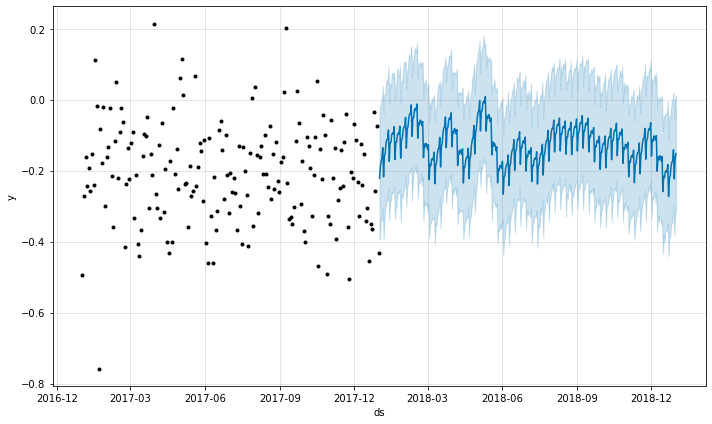

In [11]:
#start fitting data using Prophet model
m_2017 = Prophet(yearly_seasonality=True, daily_seasonality=True)
#fit model with 2017 data, use the to predict 2018 data
m_2017.fit(df_2017)
future_2018 = m_2017.make_future_dataframe(periods=365)[-365:]
forecast_2018 = m_2017.predict(future_2018)
y_hat_2018 = forecast_2018[['ds','yhat']]
print(y_hat_2018)
fig1 = m_2017.plot(forecast_2018)

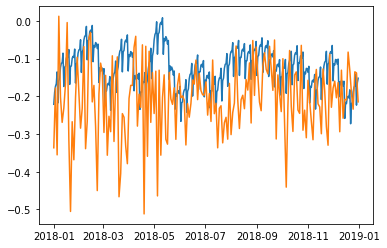

In [19]:
#plot predicted_2018 vs true_2018 to check for similarities
plt.plot(y_hat_2018['ds'], y_hat_2018['yhat'])
plt.plot(df_2018['ds'],df_2018['y'])

In [ ]:
#TODO: Check for correlation between these two years
#TODO: investigate changepoints of the prophet model
#TODO: Try to smooth initial data more
